## Main Manova 3PCs and removing corr > 0.5 HLA alleles from PCA


In [4]:
source('R_functions/cdr3-QTL_functions.R')
source('R_functions//hla_functions.R')
source('libraries.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘arrow’


The following obje

### updated version in 30.10.24

#### preparing cdr3-hla-matrices as in Ishigaki

In [5]:
hla_genotypes_matrix_wo_low_ab <- fread('../data/hla/hla_genotypes_matrix_wo_low_ab.csv')
pca_hla <- pca_hla_fun(hla_genotypes_matrix_wo_low_ab, 0.5, 3)
fwrite(pca_hla, '../data/hla/pca_hla_as_Ishigaki.tsv', sep = '\t')

In [12]:
dir_pair_path <- paste0('../cdr3_hla_pairs/as_in_Ishigaki/')
hla_matrices <- paste0('../hla_matrices_v3/all/',list.files('../hla_matrices_v3/all/'))
files_group <- paste0('../cdr3_hla_pairs//CDR3_GROUPS_IRT/', list.files('../cdr3_hla_pairs//CDR3_GROUPS_IRT/')) 

prep_mode <- c('irt_freq_unique')

for (L_P_group in files_group){

    cdr3_L_P <- fread(L_P_group)
   
    L <- unique(cdr3_L_P$length_seq)
    P <- unique(cdr3_L_P$IMGT)
        
    cdr3_matrix <- dcast(cdr3_L_P, patient_id ~ AA, value.var = prep_mode)
            
        for (f in hla_matrices){
            
            hla_matrix <- fread(f) %>% left_join(pca_hla, by = 'patient_id')
            hla_matrix$G_S <- gsub(':', '_', hla_matrix$G_S)
            new_path <- gsub('/all/', '/as_in_Ishigaki/', f)
            fwrite(hla_matrix, new_path)
            
            cdr3_hla_matrix <- merge(hla_matrix, cdr3_matrix, by = 'patient_id', all.x = TRUE)
            cdr3_hla_matrix$pair <- paste0(hla_matrix$G_S[1],'_', L, '_', P)
            name_pair <- cdr3_hla_matrix$pair[1]
    
            cdr3_hla_matrix[, G_S := NULL]
            fwrite(cdr3_hla_matrix, paste0(dir_pair_path,name_pair,'_matrix.tsv'), sep = '\t')
            
        }
        }



### Main Manova as in Ishigaki

In [ ]:
pairs <- '../cdr3_hla_pairs/as_in_Ishigaki/'
dir_pair_path <- paste0(pairs, list.files(pairs))
dir_results <- '../manova_results_v3/as_in_Ishigaki_removing_90_correlated/'
if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
pcs <- 3

first <- TRUE
for (f in dir_pair_path){
    
    cdr3_hla_matrix <- na.omit(fread(f)) 
    name_pair <- cdr3_hla_matrix$pair[1]
    
    manova_df <- mlm_fun(cdr3_hla_matrix, dir_results, n_pcs = pcs)
    if (first){
        manova_df_all <- manova_df[0,]
        first <- FALSE
    }
    if (is.null(manova_df)){
        next
    } else {
        manova_df_all <- rbind(manova_df_all, manova_df) 
        }
    }

manova_df_all <- manova_df_all %>% separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = '_', remove = FALSE)
fwrite(manova_df_all, paste0(dir_results, '../main_manova_as_in_Ishigaki_removing_90_corr.tsv'), sep = '\t')

Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):


### Conditional as in Ishigaki

In [ ]:
hla_matrices <- '../hla_matrices_v3/all/'
dir_analysis <- '../conditional_analysis/as_in_ishigaki/'

if (!file.exists(dir_analysis)) {
    dir.create(dir_analysis, recursive = TRUE)
    }
pairs <- '../cdr3_hla_pairs/as_in_Ishigaki/'
pairs_to_test <- paste0(pairs, list.files(pairs))
#pairs_to_test <- grep('DRB1_', paste0(pairs, list.files(pairs)), value = TRUE) ---- when analyzing in gene-site level
pcs <- 3
manova_cond_all <- fread('../main_manova_as_in_Ishigaki_removing_90_corr.tsv')
bonf <- 0.01 / nrow(na.omit(manova_cond_all))

source('Conditional_analysis_updated.R')

Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):


### MANOVA and Conditional in DOWNSAMPLED CDR3

In [84]:
source('libraries.R')
source('R_functions//cdr3-QTL_functions.R')

In [ ]:
hla_genotypes_matrix_wo_low_ab <- fread('../data/hla/hla_genotypes_matrix_wo_low_ab.csv')
pca_hla <- fread('../data/hla/pca_hla_9PCs.tsv')
hla_matrices <- paste0('../hla_matrices_v3/with_pcs/',list.files('../hla_matrices_v3/with_pcs/'))

dir_downsampling <- '../CDR3_downsampling_experiment/'
dir_content <- paste0(dir_downsampling, list.files(dir_downsampling))

for (path_in in dir_content[5:length(dir_content)]){
    sample_size <- unlist(strsplit(path_in, '/'))[3]
    source('Manova_Downsampled_CDR3.r')
    dfs_together(dir_results, paste0(dir_results, '../', sample_size, '_manova.tsv'))
                 }

### Conditional on Downsampled CDR3

In [ ]:
hla_matrices <- paste0('../hla_matrices_v3/with_pcs/',list.files('../hla_matrices_v3/with_pcs/'))
pcs <- 3

for (path_in in dir_content{
    dir_analysis <- paste0(path_in, '/conditional_analysis/')
    if (!file.exists(dir_analysis)) {
        dir.create(dir_analysis, recursive = TRUE)
        }
    pairs_to_test <- paste0(path_in,'/cdr3_hla_pairs/')
    sample_size <- unlist(strsplit(path_in, '/'))[3]
    manova_cond_all <- fread(paste0(path_in,'/',sample_size,'_manova.tsv'))
    bonf <- 0.01 / nrow(na.omit(manova_cond_all))
            
    source('Conditional_analysis_updated.R')
                 }

### Mapping IBD patients with UC and CD

In [4]:
cd_uc <- fread('../phenotype_mapping.tsv')

In [5]:
colnames(cd_uc) <- c('patient_id', 'IBD_subtype')

In [6]:
cd_uc$patient_id <- gsub('sample_', 'I', cd_uc$patient_id)

In [8]:
summary_ibd <- cd_uc %>% group_by(IBD_subtype) %>% count()

In [70]:
summary_ibd

IBD_subtype n   
1 CD          1026
2 UC           402

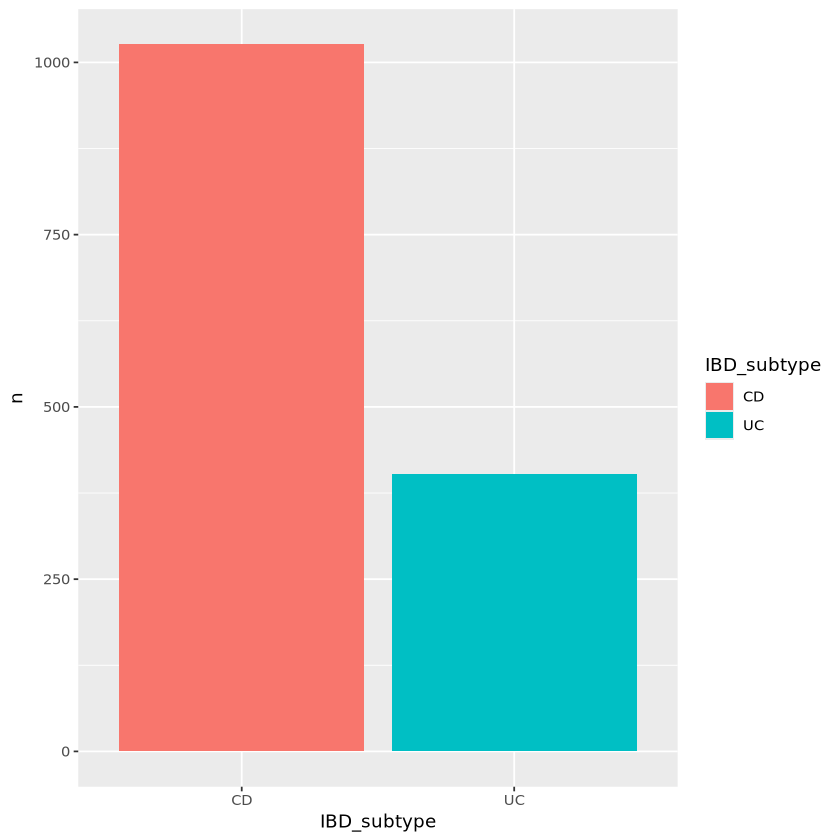

In [10]:
ggplot(summary_ibd, aes(x = IBD_subtype, y = n, fill = IBD_subtype)) +
geom_col()

In [107]:
sites_to_test <- grep('.tsv',
                      list.files('../conditional_analysis//IBD//gene_wise//DQB1/'),
                                value = TRUE, invert = TRUE)

In [111]:
pairs <- '../IBD//cdr3_hla_pairs/'
pairs <- paste0(pairs, list.files(pairs))
indexes <- grepl(paste(paste0(sites_to_test, '_'), collapse = '|'), pairs)
pairs_to_test <- pairs[indexes]
length(pairs_to_test)

[1] 420

In [112]:
pairs_to_test

[1] "../IBD//cdr3_hla_pairs/DQB1_224_12_P106_matrix.tsv"  
  [2] "../IBD//cdr3_hla_pairs/DQB1_224_12_P107_matrix.tsv"  
  [3] "../IBD//cdr3_hla_pairs/DQB1_224_12_P108_matrix.tsv"  
  [4] "../IBD//cdr3_hla_pairs/DQB1_224_12_P109_matrix.tsv"  
  [5] "../IBD//cdr3_hla_pairs/DQB1_224_12_P113_matrix.tsv"  
  [6] "../IBD//cdr3_hla_pairs/DQB1_224_12_P114_matrix.tsv"  
  [7] "../IBD//cdr3_hla_pairs/DQB1_224_12_P115_matrix.tsv"  
  [8] "../IBD//cdr3_hla_pairs/DQB1_224_12_P116_matrix.tsv"  
  [9] "../IBD//cdr3_hla_pairs/DQB1_224_13_P106_matrix.tsv"  
 [10] "../IBD//cdr3_hla_pairs/DQB1_224_13_P107_matrix.tsv"  
 [11] "../IBD//cdr3_hla_pairs/DQB1_224_13_P108_matrix.tsv"  
 [12] "../IBD//cdr3_hla_pairs/DQB1_224_13_P109_matrix.tsv"  
 [13] "../IBD//cdr3_hla_pairs/DQB1_224_13_P110_matrix.tsv"  
 [14] "../IBD//cdr3_hla_pairs/DQB1_224_13_P113_matrix.tsv"  
 [15] "../IBD//cdr3_hla_pairs/DQB1_224_13_P114_matrix.tsv"  
 [16] "../IBD//cdr3_hla_pairs/DQB1_224_13_P115_matrix.tsv"  
 [17] "../IBD//cdr3_hla_pairs/DQB1_224_13_P116_matrix.tsv"  
 [18] "../IBD//cdr3_hla_pairs/DQB1_224_14_P106_matrix.tsv"  
 [19] "../IBD//cdr3_hla_pairs/DQB1_224_14_P107_matrix.tsv"  
 [20] "../IBD//cdr3_hla_pairs/DQB1_224_14_P108_matrix.tsv"  
 [21] "../IBD//cdr3_hla_pairs/DQB1_224_14_P109_matrix.tsv"  
 [22] "../IBD//cdr3_hla_pairs/DQB1_224_14_P110_matrix.tsv"  
 [23] "../IBD//cdr3_hla_pairs/DQB1_224_14_P112_matrix.tsv"  
 [24] "../IBD//cdr3_hla_pairs/DQB1_224_14_P113_matrix.tsv"  
 [25] "../IBD//cdr3_hla_pairs/DQB1_224_14_P114_matrix.tsv"  
 [26] "../IBD//cdr3_hla_pairs/DQB1_224_14_P115_matrix.tsv"  
 [27] "../IBD//cdr3_hla_pairs/DQB1_224_14_P116_matrix.tsv"  
 [28] "../IBD//cdr3_hla_pairs/DQB1_224_15_P106_matrix.tsv"  
 [29] "../IBD//cdr3_hla_pairs/DQB1_224_15_P107_matrix.tsv"  
 [30] "../IBD//cdr3_hla_pairs/DQB1_224_15_P108_matrix.tsv"  
 [31] "../IBD//cdr3_hla_pairs/DQB1_224_15_P109_matrix.tsv"  
 [32] "../IBD//cdr3_hla_pairs/DQB1_224_15_P110_matrix.tsv"  
 [33] "../IBD//cdr3_hla_pairs/DQB1_224_15_P111_matrix.tsv"  
 [34] "../IBD//cdr3_hla_pairs/DQB1_224_15_P112_matrix.tsv"  
 [35] "../IBD//cdr3_hla_pairs/DQB1_224_15_P113_matrix.tsv"  
 [36] "../IBD//cdr3_hla_pairs/DQB1_224_15_P114_matrix.tsv"  
 [37] "../IBD//cdr3_hla_pairs/DQB1_224_15_P115_matrix.tsv"  
 [38] "../IBD//cdr3_hla_pairs/DQB1_224_16_P106_matrix.tsv"  
 [39] "../IBD//cdr3_hla_pairs/DQB1_224_16_P107_matrix.tsv"  
 [40] "../IBD//cdr3_hla_pairs/DQB1_224_16_P108_matrix.tsv"  
 [41] "../IBD//cdr3_hla_pairs/DQB1_224_16_P109_matrix.tsv"  
 [42] "../IBD//cdr3_hla_pairs/DQB1_224_16_P110_matrix.tsv"  
 [43] "../IBD//cdr3_hla_pairs/DQB1_224_16_P111_matrix.tsv"  
 [44] "../IBD//cdr3_hla_pairs/DQB1_224_16_P112_matrix.tsv"  
 [45] "../IBD//cdr3_hla_pairs/DQB1_224_16_P112.1_matrix.tsv"
 [46] "../IBD//cdr3_hla_pairs/DQB1_224_16_P113_matrix.tsv"  
 [47] "../IBD//cdr3_hla_pairs/DQB1_224_16_P114_matrix.tsv"  
 [48] "../IBD//cdr3_hla_pairs/DQB1_224_16_P115_matrix.tsv"  
 [49] "../IBD//cdr3_hla_pairs/DQB1_224_17_P106_matrix.tsv"  
 [50] "../IBD//cdr3_hla_pairs/DQB1_224_17_P107_matrix.tsv"  
 [51] "../IBD//cdr3_hla_pairs/DQB1_224_17_P108_matrix.tsv"  
 [52] "../IBD//cdr3_hla_pairs/DQB1_224_17_P109_matrix.tsv"  
 [53] "../IBD//cdr3_hla_pairs/DQB1_224_17_P110_matrix.tsv"  
 [54] "../IBD//cdr3_hla_pairs/DQB1_224_17_P111_matrix.tsv"  
 [55] "../IBD//cdr3_hla_pairs/DQB1_224_17_P111.1_matrix.tsv"
 [56] "../IBD//cdr3_hla_pairs/DQB1_224_17_P112_matrix.tsv"  
 [57] "../IBD//cdr3_hla_pairs/DQB1_224_17_P112.1_matrix.tsv"
 [58] "../IBD//cdr3_hla_pairs/DQB1_224_17_P113_matrix.tsv"  
 [59] "../IBD//cdr3_hla_pairs/DQB1_224_17_P114_matrix.tsv"  
 [60] "../IBD//cdr3_hla_pairs/DQB1_224_18_P107_matrix.tsv"  
 [61] "../IBD//cdr3_hla_pairs/DQB1_224_18_P108_matrix.tsv"  
 [62] "../IBD//cdr3_hla_pairs/DQB1_224_18_P109_matrix.tsv"  
 [63] "../IBD//cdr3_hla_pairs/DQB1_224_18_P110_matrix.tsv"  
 [64] "../IBD//cdr3_hla_pairs/DQB1_224_18_P111_matrix.tsv"  
 [65] "../IBD//cdr3_hla_pairs/DQB1_224_18_P111.1_matrix.tsv"
 [66] "../IBD//cdr3_hla_pairs/DQB1_22

In [113]:
dir_results <- '../IBD/manova_uc/'
first <- TRUE
for (f in pairs_to_test){
    cdr3_hla_pair <- fread(f)
    cdr3_hla_matrix <- merge(cdr3_hla_pair, cd_uc, by = 'patient_id') %>% filter(IBD_subtype == 'UC')
    manova_df <- mlm_fun(cdr3_hla_matrix, dir_results, n_pcs = 3)
    if (first){
        manova_df_all <- manova_df[0,]
        first <- FALSE
    }
    if (is.null(manova_df)){
        next
    } else {
        manova_df_all <- rbind(manova_df_all, manova_df) 
        }
    }
    
fwrite(manova_df_all, paste0(dir_results, 'manova_UC_DQB1.tsv'), sep = '\t')

Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 38
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 38
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Error: Error in if (na.omit(manova_df)$`Pr(>F)` < bonf) {: argument is of length zero


Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 34
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 34
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size i

Warning message:
“Removed 1260 rows containing missing values or values outside the scale range (`geom_point()`).”


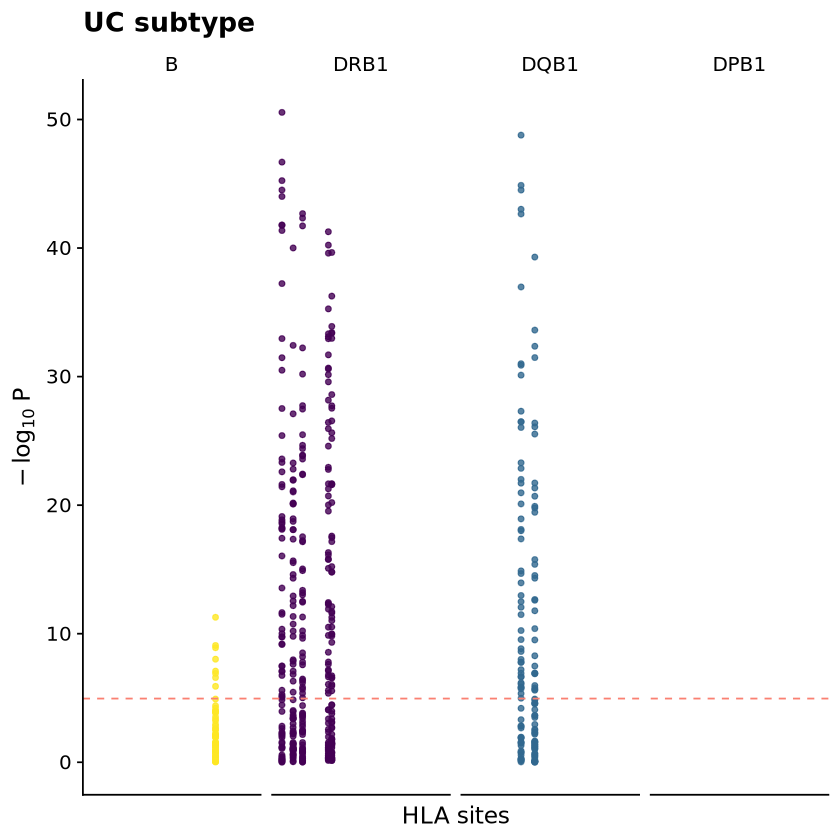

In [63]:
bonf <- 0.01 / 900
hla_genes <- c('A', 'C', 'B','DRB1','DQA1','DQB1','DPA1', 'DPB1')
manova_uc <- manova_df_all %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla))
pl_manova_uc <- ggplot() +
    geom_point(data = manova_uc, aes(x = Site_hla, y = -log10(`Pr(>F)`), color=as.factor(HLA)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d('magma', direction = -1) +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "salmon") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"),  
          axis.ticks.x=element_blank()) +
    ggtitle('UC subtype') #+
    #ylim(0,250)
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl_manova_uc
#ggsave('../plots/manhattan_plot_wo_correlation_9PCs.jpg',pl_ours_9PCs, width = 10, height = 4)

In [115]:
dir_results <- '../IBD/manova_cd/'
first <- TRUE
for (f in pairs_to_test){
    cdr3_hla_pair <- fread(f)
    cdr3_hla_matrix <- merge(cdr3_hla_pair, cd_uc, by = 'patient_id') %>% filter(IBD_subtype == 'CD')
    cdr3_hla_matrix <- cdr3_hla_matrix[sample(nrow(cdr3_hla_matrix), 400)]
    manova_df <- mlm_fun(cdr3_hla_matrix, dir_results, n_pcs = 3)
    if (first){
        manova_df_all <- manova_df[0,]
        first <- FALSE
    }
    if (is.null(manova_df)){
        next
    } else {
        manova_df_all <- rbind(manova_df_all, manova_df) 
        }
    }
fwrite(manova_df_all, paste0(dir_results, 'manova_dCD_DQB1.tsv'), sep = '\t')

Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 56
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 56
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Error: Error in if (na.omit(manova_df)$`Pr(>F)` < bonf) {: argument is of length zero


Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 39
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 39
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size i

Warning message:
“Removed 1260 rows containing missing values or values outside the scale range (`geom_point()`).”


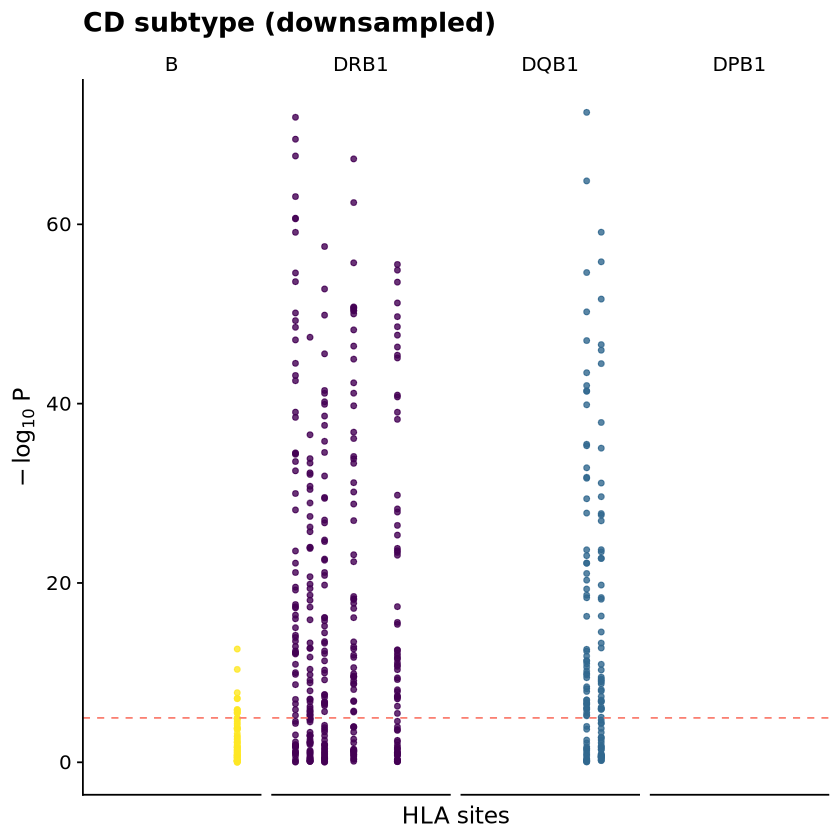

In [79]:
bonf <- 0.01 / 900
hla_genes <- c('A', 'C', 'B','DRB1','DQA1','DQB1','DPA1', 'DPB1')
manova_cd <- manova_df_all %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla))
pl_manova_cd <- ggplot() +
    geom_point(data = manova_cd, aes(x = as.factor(Site_hla), y = -log10(`Pr(>F)`), color=as.factor(HLA)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d('magma', direction = -1) +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "salmon") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"),  
          axis.ticks.x=element_blank()) +
    ggtitle('CD subtype (downsampled)') #+
    #ylim(0,250)
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl_manova_cd
#ggsave('../plots/manhattan_plot_wo_correlation_9PCs.jpg',pl_ours_9PCs, width = 10, height = 4)

In [117]:
cd <- fread('../IBD/manova_cd/manova_dCD_DQB1.tsv') %>% mutate(IBD_subtype = 'CD')
uc <- fread('../IBD/manova_uc/manova_UC_DQB1.tsv') %>% mutate(IBD_subtype = 'UC')
manova_both <- rbind(cd, uc) 

In [121]:
manova_both <- manova_both %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

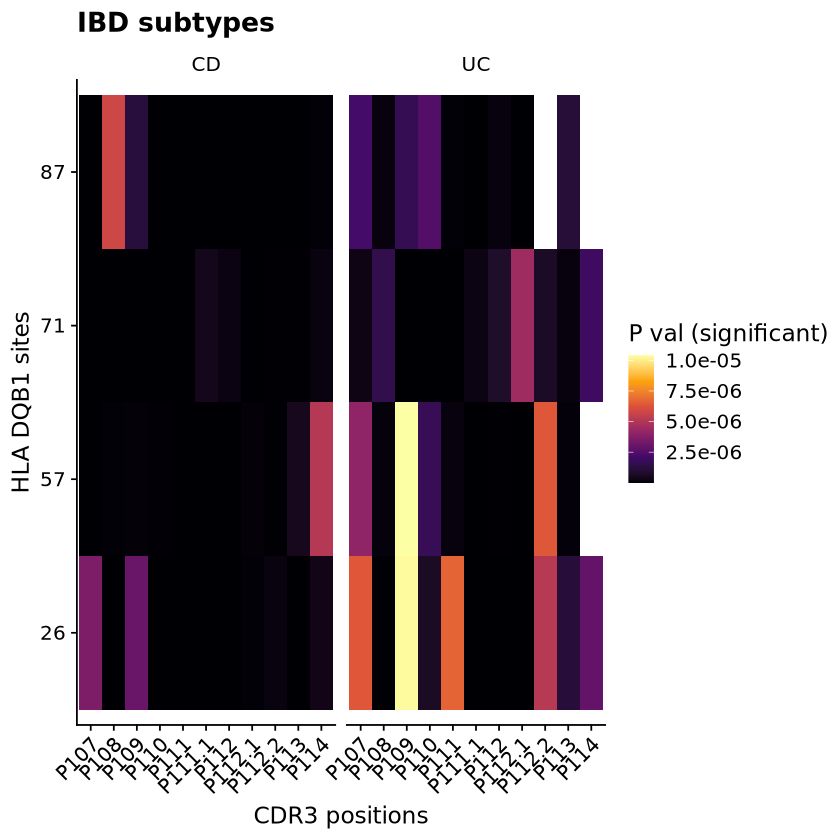

In [129]:
cd_uc_plot <- ggplot(data = manova_both %>% filter(`Pr(>F)` < 0.01/900), aes(x = Position_cdr3, y = as.factor(Site_hla), fill = `Pr(>F)`)) + 
    geom_tile() +
    scale_fill_viridis_c( option = 'inferno') + 
    theme_cowplot() +
    labs( x = 'CDR3 positions', y = 'HLA DQB1 sites', fill = 'P val (significant)', title = 'IBD subtypes') +
    facet_grid(~ IBD_subtype , scales = 'free') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1), strip.background = element_rect(fill = "white"))
cd_uc_plot

In [127]:
0.01/900

[1] 1.111111e-05

In [130]:
ggsave('../plots/cd_vc_uc_2.png', cd_uc_plot, width = 10, height = 15)

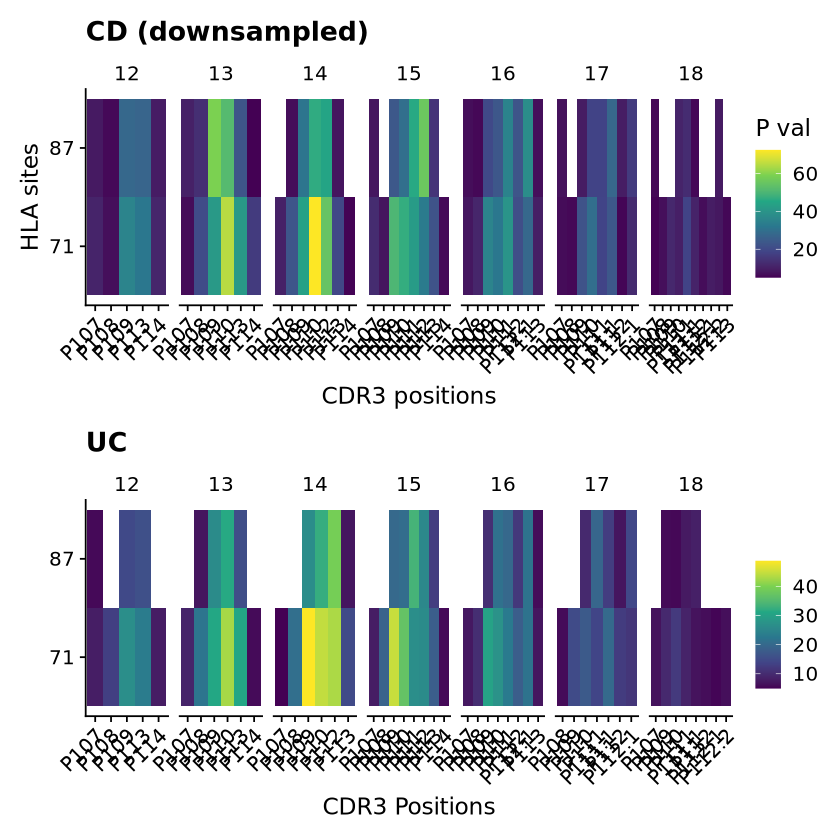

In [105]:
both

In [40]:
main_manova_healthy <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
main_manova_healthy #%>% filter(str_detect(pair, 'DQA1:25'))

In [3]:
main_manova_ibd <- na.omit(fread('../IBD/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
downsampled_manova_ibd <- na.omit(fread('../IBD/manova_results_downsampled.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
head(main_manova_ibd) #%>% filter(str_detect(pair, 'DQA1:25'))
head(downsampled_manova_ibd)

In [ ]:
main_manova <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)
hla_genes <- c('DRB1','A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1','DQB1')

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

for (gene in hla_genes){
    
    manova_df_all <- cond_manova_template
    
    gene_manova <- main_manova %>% filter(HLA == gene) 
    hit <- gene_manova$pair[1]
    g_s_l_p <- unlist(strsplit(hit, ':'))
    condition_site <- paste(g_s_l_p[1:2], collapse= '_')
    condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>%
        dplyr::select(-G_S)
    colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
    sites <- colnames(condition_site_df)[-1]
    hit_pattern <- paste0(gsub('_', ':', condition_site),':')
    pairs_to_test <- grep(hit_pattern, paste0('../HEALTHY/cdr3_hla_pairs/',grep(paste0(gene,':'), list.files('../HEALTHY/cdr3_hla_pairs/'), value = TRUE)), value = TRUE, invert = TRUE)
    dir_matrices <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/cdr3_hla_pairs/')
    dir_results <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/')
        
    if (!file.exists(dir_matrices)) {
    dir.create(dir_matrices, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
    manova_df_site <- cond_manova_template
    
    for (f in pairs_to_test){
        cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
        cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
        fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
        manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
            separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
            mutate(condition = condition_site)
        manova_df_site <- rbind(manova_df_site, manova_df)
        
    }
    fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'))
    manova_df_all <- rbind(manova_df_all, manova_df_site)

    while (nrow(manova_df_site %>% filter(Pr..F.<bonf)) > 0){
        manova_results <- na.omit(fread(paste0('../conditional_analysis/HEALTHY/',gene,'/',condition_site,'/manova_',condition_site,'.tsv'))) %>% 
            arrange(., Pr..F.,desc(variance_explained))
         
        hit <- manova_results$pair[1]
        g_s_l_p <- unlist(strsplit(hit, ':'))

        condition_site <- paste(g_s_l_p[1:2], collapse= '_')
        hit_pattern <- paste0(gsub('_', ':', condition_site),':')
        condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>% 
            dplyr::select(-G_S)
        colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
        site <- colnames(condition_site_df)[-1]
        sites <- c(sites, site)
        pairs_survived <- unique(lapply(unique(manova_results %>% filter(Pr..F. < bonf) %>% pull(pair)), function(x) paste0(paste(unlist(strsplit(x, ':'))[1:2], collapse = ':'), ':') ))
        pairs_to_test <- grep(hit_pattern, paste0(dir_matrices, grep(paste(pairs_survived, collapse = '|'), list.files(dir_matrices), value = TRUE)), value = TRUE, invert = TRUE)
    
        dir_matrices <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/cdr3_hla_pairs/')
        dir_results <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/')
            
        if (!file.exists(dir_matrices)) {
        dir.create(dir_matrices, recursive = TRUE)
        }
        if (!file.exists(dir_results)) {
        dir.create(dir_results, recursive = TRUE)
        }
        manova_df_site <- cond_manova_template
        
        for (f in pairs_to_test){
            cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
            cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
            fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
            manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
                separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
                mutate(condition = condition_site)
            manova_df_site <- rbind(manova_df_site, manova_df)
            
        }
        fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'), sep = '\t')
        manova_df_all <- rbind(manova_df_all, manova_df_site)
            
    }
    fwrite(manova_df_all, paste0('../conditional_analysis//HEALTHY/manova_',gene,'.tsv'), sep = '\t')
    }


main_manova <- na.omit(fread('../IBD/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

for (gene in hla_genes){
    
    manova_df_all <- cond_manova_template
    
    gene_manova <- main_manova %>% filter(HLA == gene) 
    hit <- gene_manova$pair[1]
    g_s_l_p <- unlist(strsplit(hit, ':'))
    condition_site <- paste(g_s_l_p[1:2], collapse= '_')
    condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>%
        dplyr::select(-G_S)
    colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
    sites <- colnames(condition_site_df)[-1]
    hit_pattern <- paste0(gsub('_', ':', condition_site),':')
    pairs_to_test <- grep(hit_pattern, paste0('../IBD/cdr3_hla_pairs/',grep(paste0(gene,':'), list.files('../IBD/cdr3_hla_pairs/'), value = TRUE)), value = TRUE, invert = TRUE)
    dir_matrices <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/cdr3_hla_pairs/')
    dir_results <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/')
        
    if (!file.exists(dir_matrices)) {
    dir.create(dir_matrices, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
    manova_df_site <- cond_manova_template
    
    for (f in pairs_to_test){
        cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
        cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
        fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
        manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
            separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
            mutate(condition = condition_site)
        manova_df_site <- rbind(manova_df_site, manova_df)
        
    }
    fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'))
    manova_df_all <- rbind(manova_df_all, manova_df_site)

    while (nrow(manova_df_site %>% filter(Pr..F.<bonf)) > 0){
        manova_results <- na.omit(fread(paste0('../conditional_analysis/IBD/',gene,'/',condition_site,'/manova_',condition_site,'.tsv'))) %>% 
            arrange(., Pr..F.,desc(variance_explained))
         
        hit <- manova_results$pair[1]
        g_s_l_p <- unlist(strsplit(hit, ':'))

        condition_site <- paste(g_s_l_p[1:2], collapse= '_')
        hit_pattern <- paste0(gsub('_', ':', condition_site),':')
        condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>% 
            dplyr::select(-G_S)
        colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
        site <- colnames(condition_site_df)[-1]
        sites <- c(sites, site)
        pairs_survived <- unique(lapply(unique(manova_results %>% filter(Pr..F. < bonf) %>% pull(pair)), function(x) paste0(paste(unlist(strsplit(x, ':'))[1:2], collapse = ':'), ':') ))
        pairs_to_test <- grep(hit_pattern, paste0(dir_matrices, grep(paste(pairs_survived, collapse = '|'), list.files(dir_matrices), value = TRUE)), value = TRUE, invert = TRUE)
    
        dir_matrices <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/cdr3_hla_pairs/')
        dir_results <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/')
            
        if (!file.exists(dir_matrices)) {
        dir.create(dir_matrices, recursive = TRUE)
        }
        if (!file.exists(dir_results)) {
        dir.create(dir_results, recursive = TRUE)
        }
        manova_df_site <- cond_manova_template
        
        for (f in pairs_to_test){
            cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
            cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
            fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
            manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
                separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
                mutate(condition = condition_site)
            manova_df_site <- rbind(manova_df_site, manova_df)
            
        }
        fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'), sep = '\t')
        manova_df_all <- rbind(manova_df_all, manova_df_site)
            
    }
    fwrite(manova_df_all, paste0('../conditional_analysis//IBD/manova_',gene,'.tsv'), sep = '\t')
    }


In [19]:
-log10(.Machine$double.xmin)

[1] 307.6527

### Across all sites in HEALTHY

In [ ]:
main_manova <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

  
manova_df_all <- cond_manova_template

hit <- main_manova$pair[1]
g_s_l_p <- unlist(strsplit(hit, ':'))
condition_site <- paste(g_s_l_p[1:2], collapse= '_')
condition_site_df <- fread(paste0('../hla_matrices_v3/wo_correlation//', grep(paste0(condition_site, '_'), list.files('../hla_matrices_v3/wo_correlation//'), value = TRUE))) %>%
    dplyr::select(-G_S)
colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
sites <- colnames(condition_site_df)[-1]
hit_pattern <- paste0(gsub('_', ':', condition_site),':')
pairs_to_test <- grep(hit_pattern,paste0('../HEALTHY/cdr3_hla_pairs/', list.files('../HEALTHY/cdr3_hla_pairs/')), value = TRUE, invert = TRUE)
dir_matrices <- paste0('../conditional_analysis/HEALTHY/all/',condition_site,'/cdr3_hla_pairs/')
dir_results <- paste0('../conditional_analysis/HEALTHY/all/', condition_site,'/')
    
if (!file.exists(dir_matrices)) {
dir.create(dir_matrices, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}

manova_df_site <- cond_manova_template

for (f in pairs_to_test){
    cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
    cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
    fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
    manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
        separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
        mutate(condition = condition_site)
    manova_df_site <- rbind(manova_df_site, manova_df)
    
}
fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'))
manova_df_all <- rbind(manova_df_all, manova_df_site)

while (nrow(manova_df_site %>% filter(Pr..F.<bonf)) > 0){
    manova_results <- na.omit(fread(paste0('../conditional_analysis/HEALTHY/all/',condition_site,'/manova_',condition_site,'.tsv'))) %>% 
        arrange(., Pr..F.,desc(variance_explained))
     
    hit <- manova_results$pair[1]
    g_s_l_p <- unlist(strsplit(hit, ':'))

    condition_site <- paste(g_s_l_p[1:2], collapse= '_')
    hit_pattern <- paste0(gsub('_', ':', condition_site),':')
    condition_site_df <- fread(paste0('../hla_matrices_v3//wo_correlation/', grep(paste0(condition_site, '_'), list.files('../hla_matrices_v3//wo_correlation/'), value = TRUE))) %>% 
        dplyr::select(-G_S)
    colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
    site <- colnames(condition_site_df)[-1]
    sites <- c(sites, site)
    pairs_survived <- unique(lapply(unique(manova_results %>% filter(Pr..F. < bonf) %>% pull(pair)), function(x) paste0(paste(unlist(strsplit(x, ':'))[1:2], collapse = ':'), ':') ))
    pairs_to_test <- grep(hit_pattern, paste0(dir_matrices, grep(paste(pairs_survived, collapse = '|'), list.files(dir_matrices), value = TRUE)), value = TRUE, invert = TRUE)

    dir_matrices <- paste0('../conditional_analysis/HEALTHY/all/', condition_site,'/cdr3_hla_pairs/')
    dir_results <- paste0('../conditional_analysis/HEALTHY/all/', condition_site,'/')
        
    if (!file.exists(dir_matrices)) {
    dir.create(dir_matrices, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
    manova_df_site <- cond_manova_template
    
    for (f in pairs_to_test){
        cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
        cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
        fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
        manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
            separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
            mutate(condition = condition_site)
        manova_df_site <- rbind(manova_df_site, manova_df)
        
    }
    fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'), sep = '\t')
    manova_df_all <- rbind(manova_df_all, manova_df_site)
        
}

fwrite(manova_df_all, paste0('../conditional_analysis/HEALTHY/all/manova_all.tsv'), sep = '\t')


Rows: 3692 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): pair, model, condition
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 2 rows [1, 2].”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning 

### Across all sites in downsampled IBD

In [ ]:
source('R_scripts/Conditional_dIBD_prev_approach.R')

Rows: 3692 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): pair, model, condition
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“r

### Conditional in Healthy removing HLA alleles wigth R-sq > 0.5 and using 9PCs

In [1]:
source('cdr3-QTL_functions.R')
source('libraries.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘purrr’


The following obje